In [1]:
from keras.optimizers import SGD
from convnetskeras.convnets import preprocess_image_batch, convnet
from convnetskeras.imagenet_tool import synset_to_dfs_ids

im = preprocess_image_batch(['examples/dog.jpg'], color_mode="bgr")

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model = convnet('alexnet',weights_path="weights/alexnet_weights.h5", heatmap=True)
model.compile(optimizer=sgd, loss='mse')

out = model.predict(im)

s = "n02084071"
ids = synset_to_dfs_ids(s)
heatmap = out[0,ids].sum(axis=0)

# Then, we can get the image
import matplotlib.pyplot as plt
plt.imsave("heatmap_dog.png",heatmap)

Using Theano backend.
Using cuDNN version 5105 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


In [68]:
from keras.optimizers import SGD
from convnetskeras.convnets import preprocess_image_batch, convnet
from convnetskeras.imagenet_tool import synset_to_dfs_ids


sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model = convnet('alexnet',weights_path="weights/alexnet_weights.h5", heatmap=True)
model.compile(optimizer=sgd, loss='mse')

print(model.summary())



____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 3, None, None) 0                                            
____________________________________________________________________________________________________
conv_1 (Convolution2D)           (None, 96, None, None 34944       input_6[0][0]                    
____________________________________________________________________________________________________
maxpooling2d_16 (MaxPooling2D)   (None, 96, None, None 0           conv_1[0][0]                     
____________________________________________________________________________________________________
convpool_1 (Lambda)              (None, 96, None, None 0           maxpooling2d_16[0][0]            
___________________________________________________________________________________________

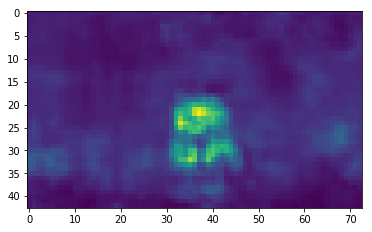

In [3]:
from keras.optimizers import SGD
from convnetskeras.convnets import preprocess_image_batch, convnet

im = preprocess_image_batch(['examples/dog.jpg'],img_size=(256,256), crop_size=(224,224), color_mode="bgr")

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
## For the VGG16, use this command
#vggmodel = convnet('vgg_16',weights_path="weights/vgg16_weights.h5", heatmap=False)
## For the VGG19, use this one instead
vggmodel = convnet('vgg_19',weights_path="weights/vgg19_weights.h5", heatmap=False)
vggmodel.compile(optimizer=sgd, loss='mse')
import matplotlib.pyplot as plt
plt.imshow(heatmap)
plt.show()


(1, 3, 1704, 2272)
(47, 64)


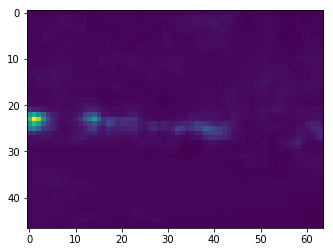

In [72]:
im = preprocess_image_batch(['examples/cars.jpg'], color_mode="bgr")
print(im.shape)
out = model.predict(im)

#s = "n02084071"
s="n04576211"

ids = synset_to_dfs_ids(s)
heatmap = out[0,ids].sum(axis=0)
print(heatmap.shape)
# Then, we can get the image
import matplotlib.pyplot as plt
plt.imshow(heatmap)
plt.show()
plt.imsave("heatmap_cars.png",heatmap)

In [1]:
import cv2
from keras.preprocessing import image
from scipy.ndimage.measurements import label

import numpy as np
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


def heatmap_boxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        print(bbox)
        new = img[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]]
        height, width = new.shape[:2]
        print(height,width)
        if (width<320):
            bbox = ((bbox[0][0]-(320-width), bbox[0][1]), (bbox[1][0], bbox[1][1]))
            print(bbox[0][0])

        if (height<320):
            bbox = ((bbox[0][0], bbox[0][1]-(320-height)), (bbox[1][0], bbox[1][1]))
            print(bbox[0][1])
        print(bbox)
        new = img[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]]
        height, width = new.shape[:2]
        print(height,width)
        if (height>=320 and width>=320):
            print(new.shape)
            new2 = cv2.resize(new,(width*4, height*4))
            new_heat=createHeatmap(new2)
            new_heat = (new_heat * 255).round().astype(np.uint8)
            plt.hist(new_heat.ravel(), bins=256,fc='k', ec='k')
            plt.show()
            new_heat = apply_threshold(new_heat,6)
            new_heat = cv2.resize(new_heat,(width*4, height*4),interpolation=cv2.INTER_NEAREST)
            structure =  np.ones((3, 3))
            labels = label(new_heat,structure=structure)
            #labels = label(new_heat)
            new_img = draw_labeled_bboxes(np.copy(new2), labels)

            plt.imshow(new_heat)
            plt.title('new_heat')
            plt.show()
            plt.imshow(new_img)
            plt.title('new')
            plt.show()

        # Return the image
    return img


def createHeatmap(img):
    
    #im = preprocess_image_batch(['examples/cars.jpg'], color_mode="bgr")
    #img= cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    #img = cv2.resize(img,(224, 224))

    im = np.asarray(img)
    height, width = im.shape[:2]
    im = cv2.resize(im,(width*2, height*2))
    im = np.asarray([im])
    

    #im = image.img_to_array([img])
    
    #print(im.shape)
    #None, 3, None, None
    #(1, 800, 1280, 3)
    #im=np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    im=np.swapaxes(im, 1, 3)
    im=np.swapaxes(im, 2, 3)
    out = model.predict(im)

    #s = "n02084071"
    s="n04576211"

    ids = synset_to_dfs_ids(s)
    heatmap = out[0,ids].sum(axis=0)
    #plt.imshow(heatmap)
    #plt.show()

    
    return heatmap

heat_map_history = []
box_history = []
frame_number = 0
num_vehicles = 0
last_boxes = []
avg_heat = None

def initializePipeline():
    global frame_number
    global heat_map_history
    global box_history
    global num_vehicles
    global last_boxes
    global avg_heat
    frame_number = 0
    num_vehicles = 0

    box_history = []
    heat_map_history=[]
    last_boxes = []
    avg_heat = None

    
def carDetectionPipelineNN(img):
    global frame_number
    global heat_map_history
    global box_history
    global num_vehicles
    global last_boxes    
    global avg_heat

    #img = cv2.resize(img,(1280, 800))

    heatmap=createHeatmap(img)
    heatmap = (heatmap * 255).round().astype(np.uint8)
    #plt.imshow(heatmap)
    #plt.show()

    # convert from 0 to 1, to 0 to 255
    #heatmap = (heatmap * 255).round().astype(np.uint8)
    im = np.asarray(img)*255
    #print(im.shape)
    height, width = im.shape[:2]
    #heatmap = apply_threshold(heatmap,25)  # 2x maybe ok
    heatmap = apply_threshold(heatmap,35)
    #heatmap = apply_threshold(heatmap,75)  # 75 is good for alexnet
    #heatmap = apply_threshold(heatmap,50)
    #heatmap = apply_threshold(heatmap,120)
    #plt.imshow(heatmap)
    #plt.show()

    #plt.hist(heatmap.ravel(), bins=256,fc='k', ec='k')
    #plt.show()
    #print(heatmap.shape)
    bigheat = cv2.resize(heatmap,(width, height),interpolation=cv2.INTER_NEAREST)
    #print(bigheat.shape)

    #print(bigheat.size)
    #plt.hist(bigheat.ravel(), bins=256,fc='k', ec='k')
    #plt.show()

    # put in averaging
    bigheat_fl = np.zeros_like(bigheat).astype(np.float)
    bigheat_fl = bigheat/255.

    heat_map_history.append(bigheat_fl)
    if (len(heat_map_history) > 5):
         del heat_map_history[0]

    # out of 10..
    # 5 slots + 10
    cur_weight=(8 - len(heat_map_history))
    avg_heat = np.zeros_like(bigheat_fl).astype(np.float)
    #plt.hist(avg_heat.ravel(), bins=256,fc='k', ec='k')
    #plt.show()
    for hm in heat_map_history:
        avg_heat = avg_heat + hm*1/8
    #plt.hist(avg_heat.ravel(), bins=256,fc='k', ec='k')
    #plt.show()
    avg_heat = avg_heat + bigheat_fl*cur_weight/8
    #plt.hist(avg_heat.ravel(), bins=256,fc='k', ec='k')
    #plt.show()
  

    
    #labels = label(bigheat)
    structure =  np.ones((3, 3))
    labels = label(avg_heat,structure=structure)

    #plt.imshow(bigheat)
    #plt.show()

    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    #a = heatmap_boxes(img, labels)

    #plt.imshow(draw_img)
    #plt.show()

    #a = heatmap_boxes(np.copy(img), labels)

    
    
    #
    # overlay heatmap or frame by frame on the top left
    #
    small_avg_heat = cv2.resize(avg_heat,None,fx=0.25, fy=0.25, interpolation = cv2.INTER_CUBIC)
    small_avg_heat = (small_avg_heat * 255).round().astype(np.uint8)

    from PIL import Image
    import matplotlib.cm as cm
    im = Image.fromarray(np.uint8(cm.hot(small_avg_heat/255)*255))
    #im = Image.fromarray(bigheat)
    im = np.asarray(im)
    im = im[:,:,0:3]
    #print(im.shape)
    draw_img[0:im.shape[0], 0:im.shape[1] ] = im
    
    

    
    return draw_img



Using Theano backend.
Using cuDNN version 5105 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


In [2]:
from keras.optimizers import SGD
from convnetskeras.convnets import preprocess_image_batch, convnet
from convnetskeras.imagenet_tool import synset_to_dfs_ids


sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model = convnet('alexnet',weights_path="weights/alexnet_weights.h5", heatmap=True)
model.compile(optimizer=sgd, loss='mse')

print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 3, None, None) 0                                            
____________________________________________________________________________________________________
conv_1 (Convolution2D)           (None, 96, None, None 34944       input_2[0][0]                    
____________________________________________________________________________________________________
maxpooling2d_3 (MaxPooling2D)    (None, 96, None, None 0           conv_1[0][0]                     
____________________________________________________________________________________________________
convpool_1 (Lambda)              (None, 96, None, None 0           maxpooling2d_3[0][0]             
___________________________________________________________________________________________

test_images/test1.jpg


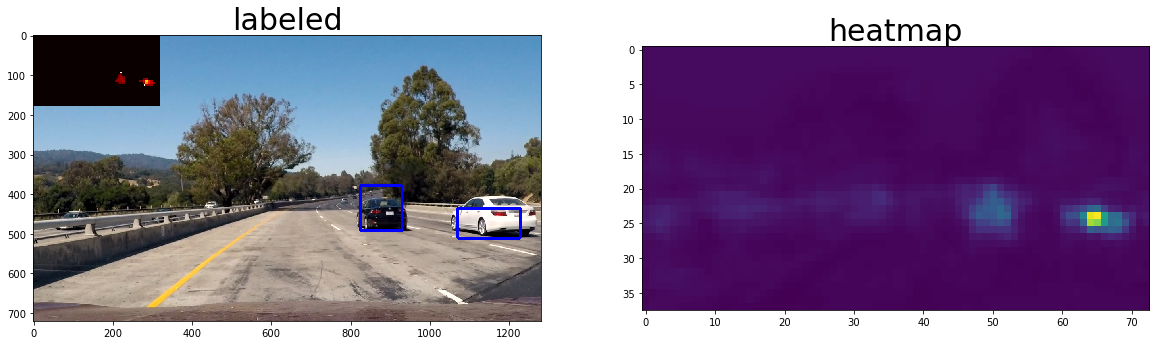

test_images/test2.jpg


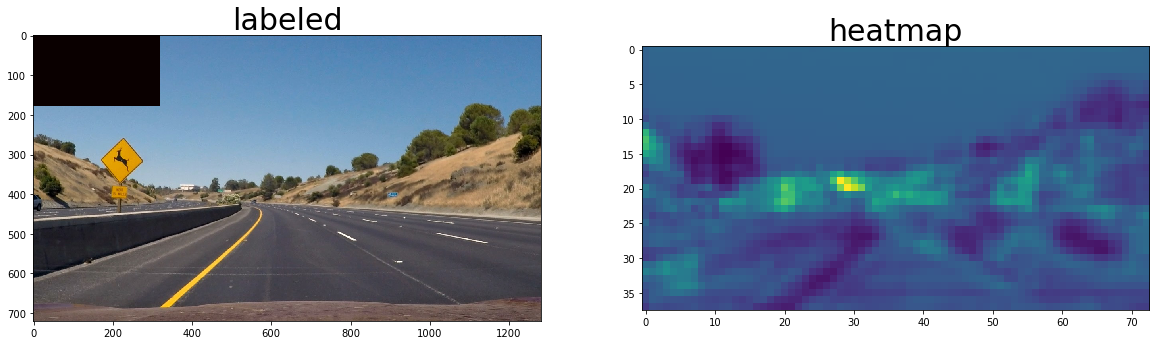

test_images/test3.jpg


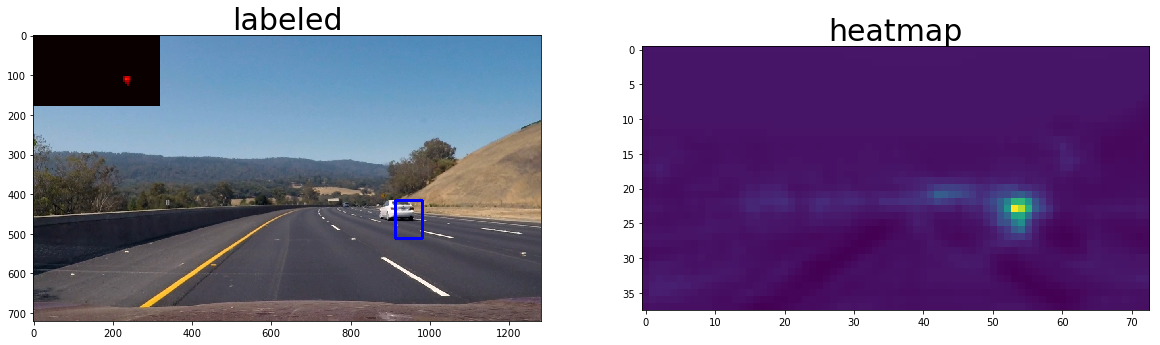

test_images/test4.jpg


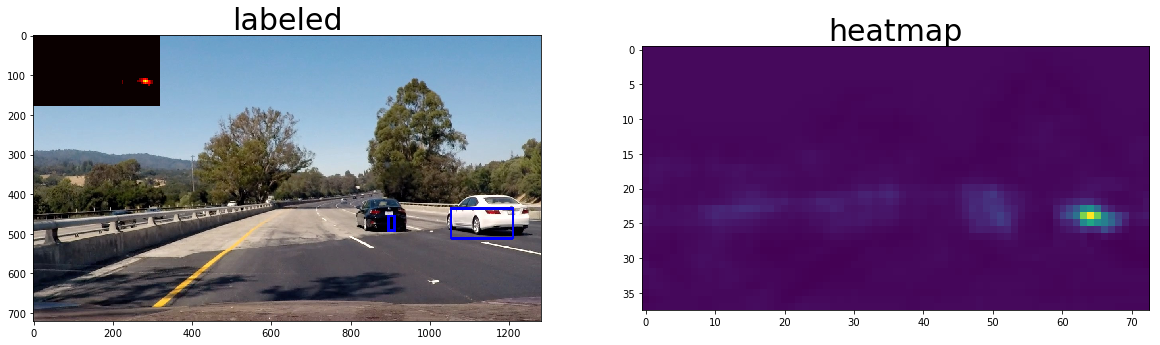

test_images/test5.jpg


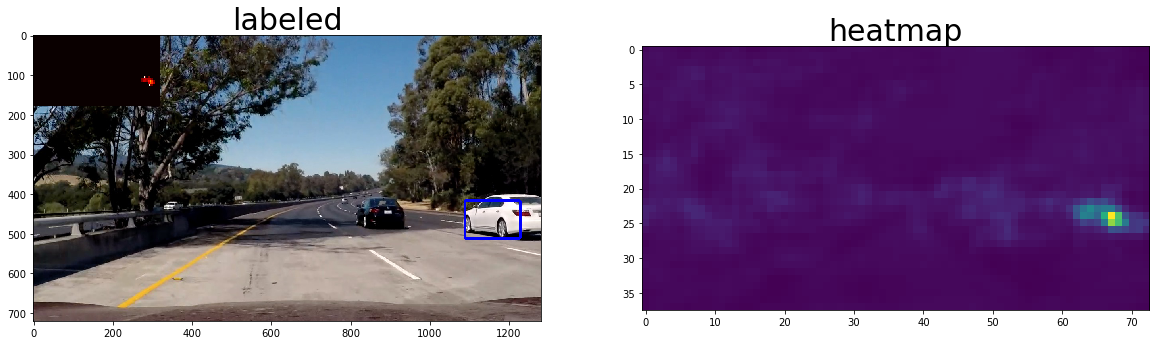

test_images/test6.jpg


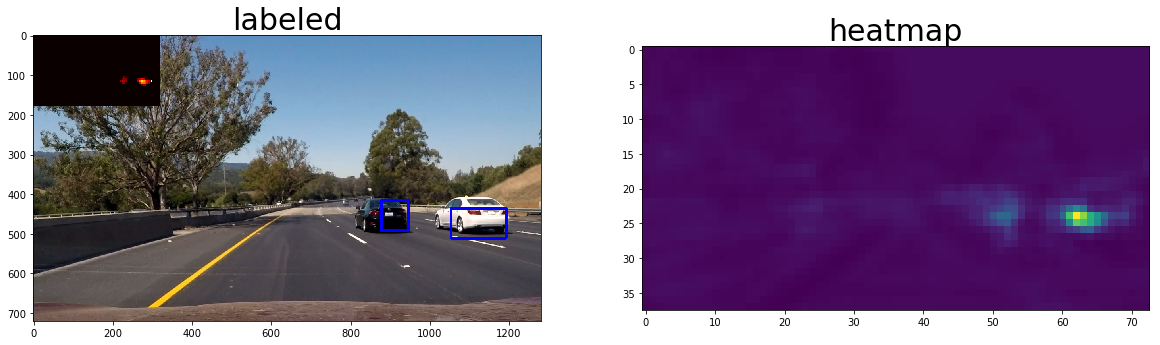

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

test_images = ['test_images/test1.jpg',
                'test_images/test2.jpg',
                'test_images/test3.jpg',
                'test_images/test4.jpg',
                'test_images/test5.jpg',
                'test_images/test6.jpg'
               ]
for image_name in test_images:
    print(image_name)
    image = mpimg.imread(image_name)
    initializePipeline()
    heatmap=createHeatmap(image)
    boxes=carDetectionPipelineNN(image)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(boxes)
    ax1.set_title('labeled', fontsize=30)
    ax2.imshow(heatmap)
    ax2.set_title('heatmap', fontsize=30)
    plt.show()


In [97]:
from moviepy.editor import VideoFileClip
def processVideo(input_video,output):
    initializePipeline()
    print('input:',input_video)
    clip1 = VideoFileClip(input_video)
    print('got clip1')
    out_clip = clip1.fl_image(carDetectionPipelineNN)
    out_clip.write_videofile(output,audio=False)



#processVideo('test_video.mp4','test_video_out.mp4')
#processVideo('project_video.mp4','project_video_convnets_out.mp4')

input: project_video.mp4
got clip1
[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [07:45<00:00,  1.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

